# 1. Set up and loading data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

train = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\train_cleaned.csv', parse_dates=["date"])
oil = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\cleaned_oil.csv', parse_dates=["date"])
holidays = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\holidays_events_cleaned.csv.csv', parse_dates=["date"])

# 2.Data Preparation

2.1 Oil Prices (Interpolate)

In [2]:
oil = oil.set_index("date").asfreq("D")
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(method="linear", limit_direction="both")
oil = oil.reset_index()

2.2 Holidays Clean Up & Categorization

In [3]:
# Để phân tích Transferred vs Original, ta KHÔNG xóa ngay, mà đánh dấu
holidays['is_transferred_date'] = holidays['transferred'] # Ngày gốc bị dời đi (đi làm)
holidays['is_transfer_event'] = holidays['type'] == 'Transfer' # Ngày nghỉ bù (nghỉ)
holidays['is_bridge'] = holidays['type'] == 'Bridge'

# Deduplication logic: Ưu tiên sự kiện nghỉ thực tế -> National -> Regional -> Local
def prioritize_holiday(x):
    if x['type'] == 'Bridge': return 1
    if x['type'] == 'Transfer': return 2
    if x['type'] == 'Holiday': return 3
    return 4

holidays['priority'] = holidays.apply(prioritize_holiday, axis=1)
holidays = holidays.sort_values(by=['date', 'priority'])
# Lưu ý: Ta vẫn giữ duplicate nhẹ ở bước này để phân tích, sau đó mới dedup khi merge chính
holidays_unique = holidays.drop_duplicates(subset=['date'], keep='first')

2.3 Main Merge 

In [4]:
daily_sales = train.groupby("date")["sales"].sum().reset_index()
df = daily_sales.merge(oil, on="date", how="left")
df = df.merge(holidays_unique[['date', 'type', 'locale', 'description', 'transferred']], 
              on="date", how="left")


2.4 Advanced Flagging

In [5]:
# Flag cơ bản
df['is_holiday_event'] = (df['type'].notna()) & (df['transferred'] == False) 
df['holiday_category'] = df['type'].fillna('Normal')
df['locale_category'] = df['locale'].fillna('None')

# Flag Window (Before/During/After)
holiday_dates = df[df['is_holiday_event']]['date']
df['period_type'] = 'Normal'
df.loc[df['date'].isin(holiday_dates), 'period_type'] = 'During Holiday'
# Before 2 days
df.loc[df['date'].isin([d - pd.Timedelta(days=i) for d in holiday_dates for i in range(1, 3)]) & (df['period_type']=='Normal'), 'period_type'] = 'Before Holiday'
# After 2 days
df.loc[df['date'].isin([d + pd.Timedelta(days=i) for d in holiday_dates for i in range(1, 3)]) & (df['period_type']=='Normal'), 'period_type'] = 'After Holiday'

# Flag Lag Oil
for lag in [1, 7, 14, 30, 365]:
    df[f'oil_lag_{lag}'] = df['dcoilwtico'].shift(lag)

print("Data Preparation Completed.")

Data Preparation Completed.


# 3. VISUALIZATIONS

3.1 OIL ANALYSIS

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34920\1919259257.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'Lag {l}' for l in lags], y=corrs, ax=axes[2], palette='Reds')


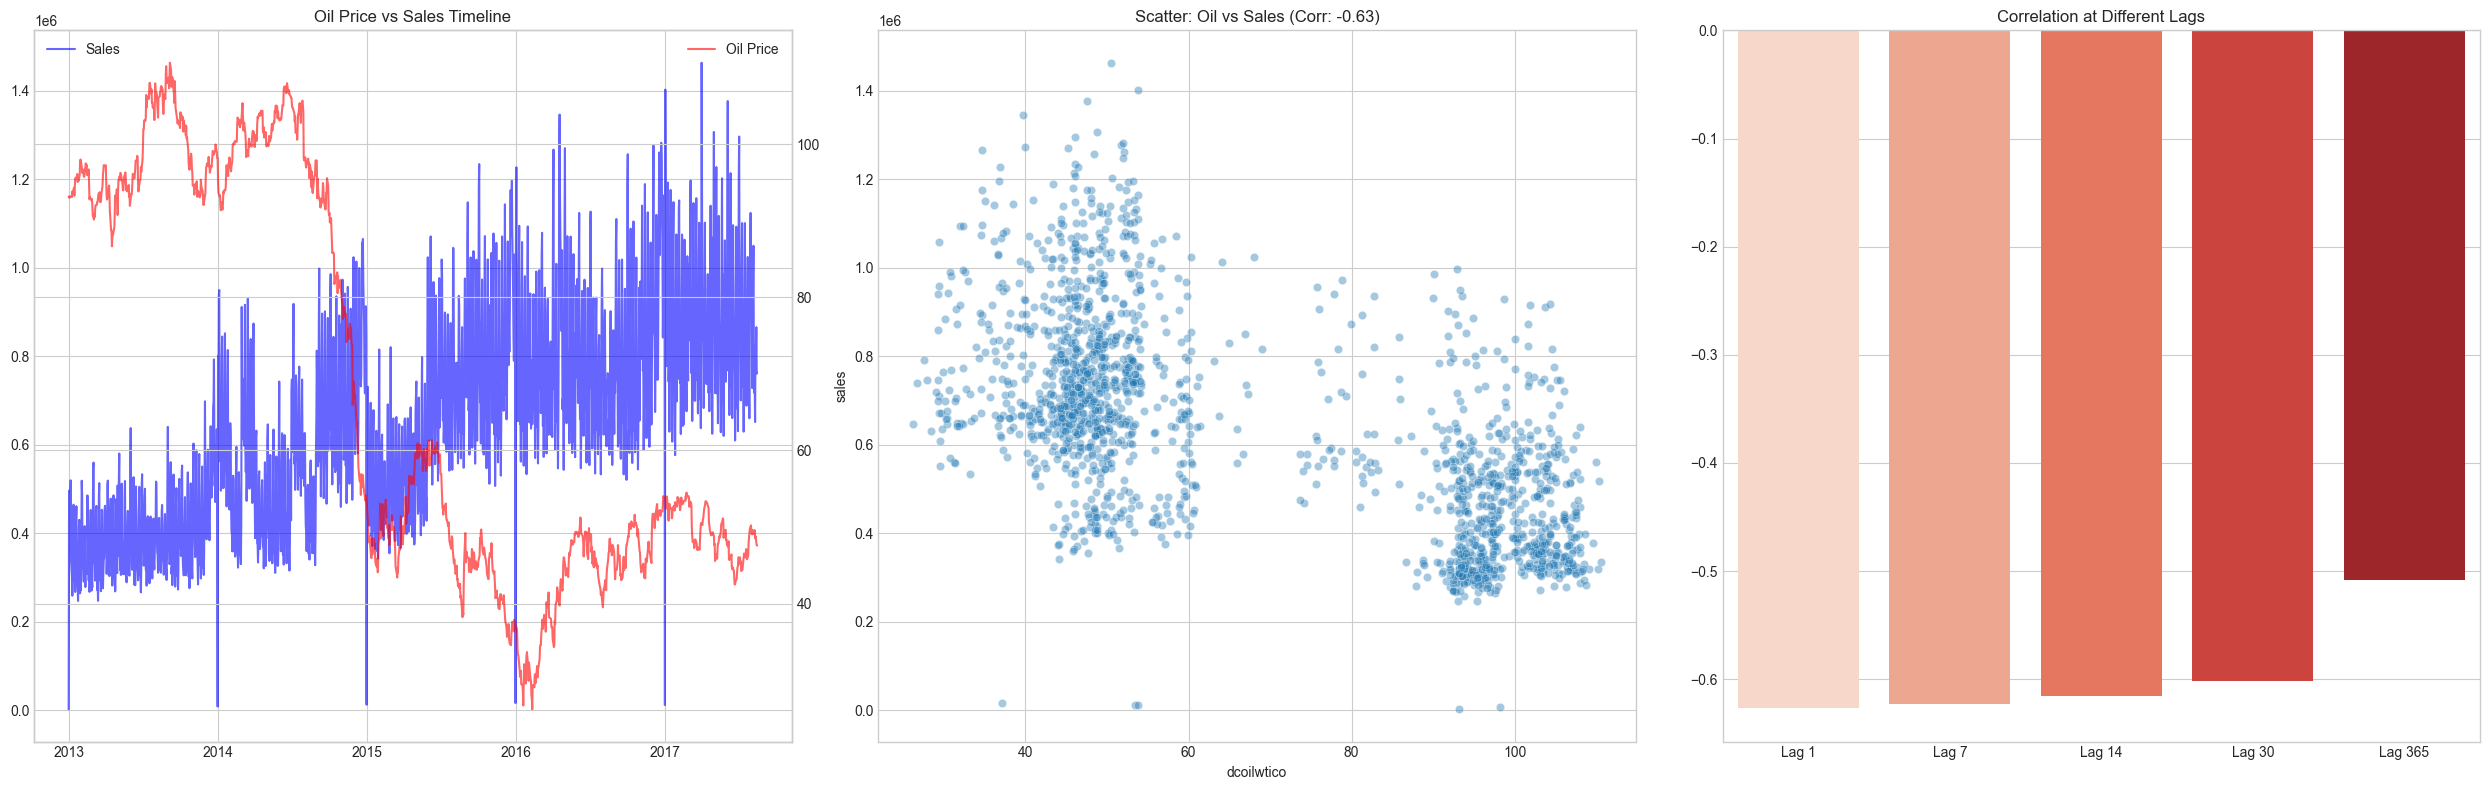

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# A. Line Chart Overlay
ax1 = axes[0]
ax1.plot(df['date'], df['sales'], color='blue', alpha=0.6, label='Sales')
ax2 = ax1.twinx()
ax2.plot(df['date'], df['dcoilwtico'], color='red', alpha=0.6, label='Oil Price')
ax1.set_title("Oil Price vs Sales Timeline")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# B. Scatter Plot
sns.scatterplot(data=df, x='dcoilwtico', y='sales', ax=axes[1], alpha=0.4)
axes[1].set_title(f"Scatter: Oil vs Sales (Corr: {df['sales'].corr(df['dcoilwtico']):.2f})")

# C. Lag Correlation Bar Chart
lags = [1, 7, 14, 30, 365]
corrs = [df['sales'].corr(df[f'oil_lag_{l}']) for l in lags]
sns.barplot(x=[f'Lag {l}' for l in lags], y=corrs, ax=axes[2], palette='Reds')
axes[2].set_title("Correlation at Different Lags")
plt.tight_layout()
plt.show()


3.2 HOLIDAY ANALYSIS: TYPES & REGIONAL

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34920\3578624429.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='holiday_category', y='sales', order=type_order, ax=axes[0, 1], palette='viridis')
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34920\3578624429.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[df['locale_category']!='None'], x='locale_category', y='sales', order=locale_order, ax=axes[1, 0], palette='magma')


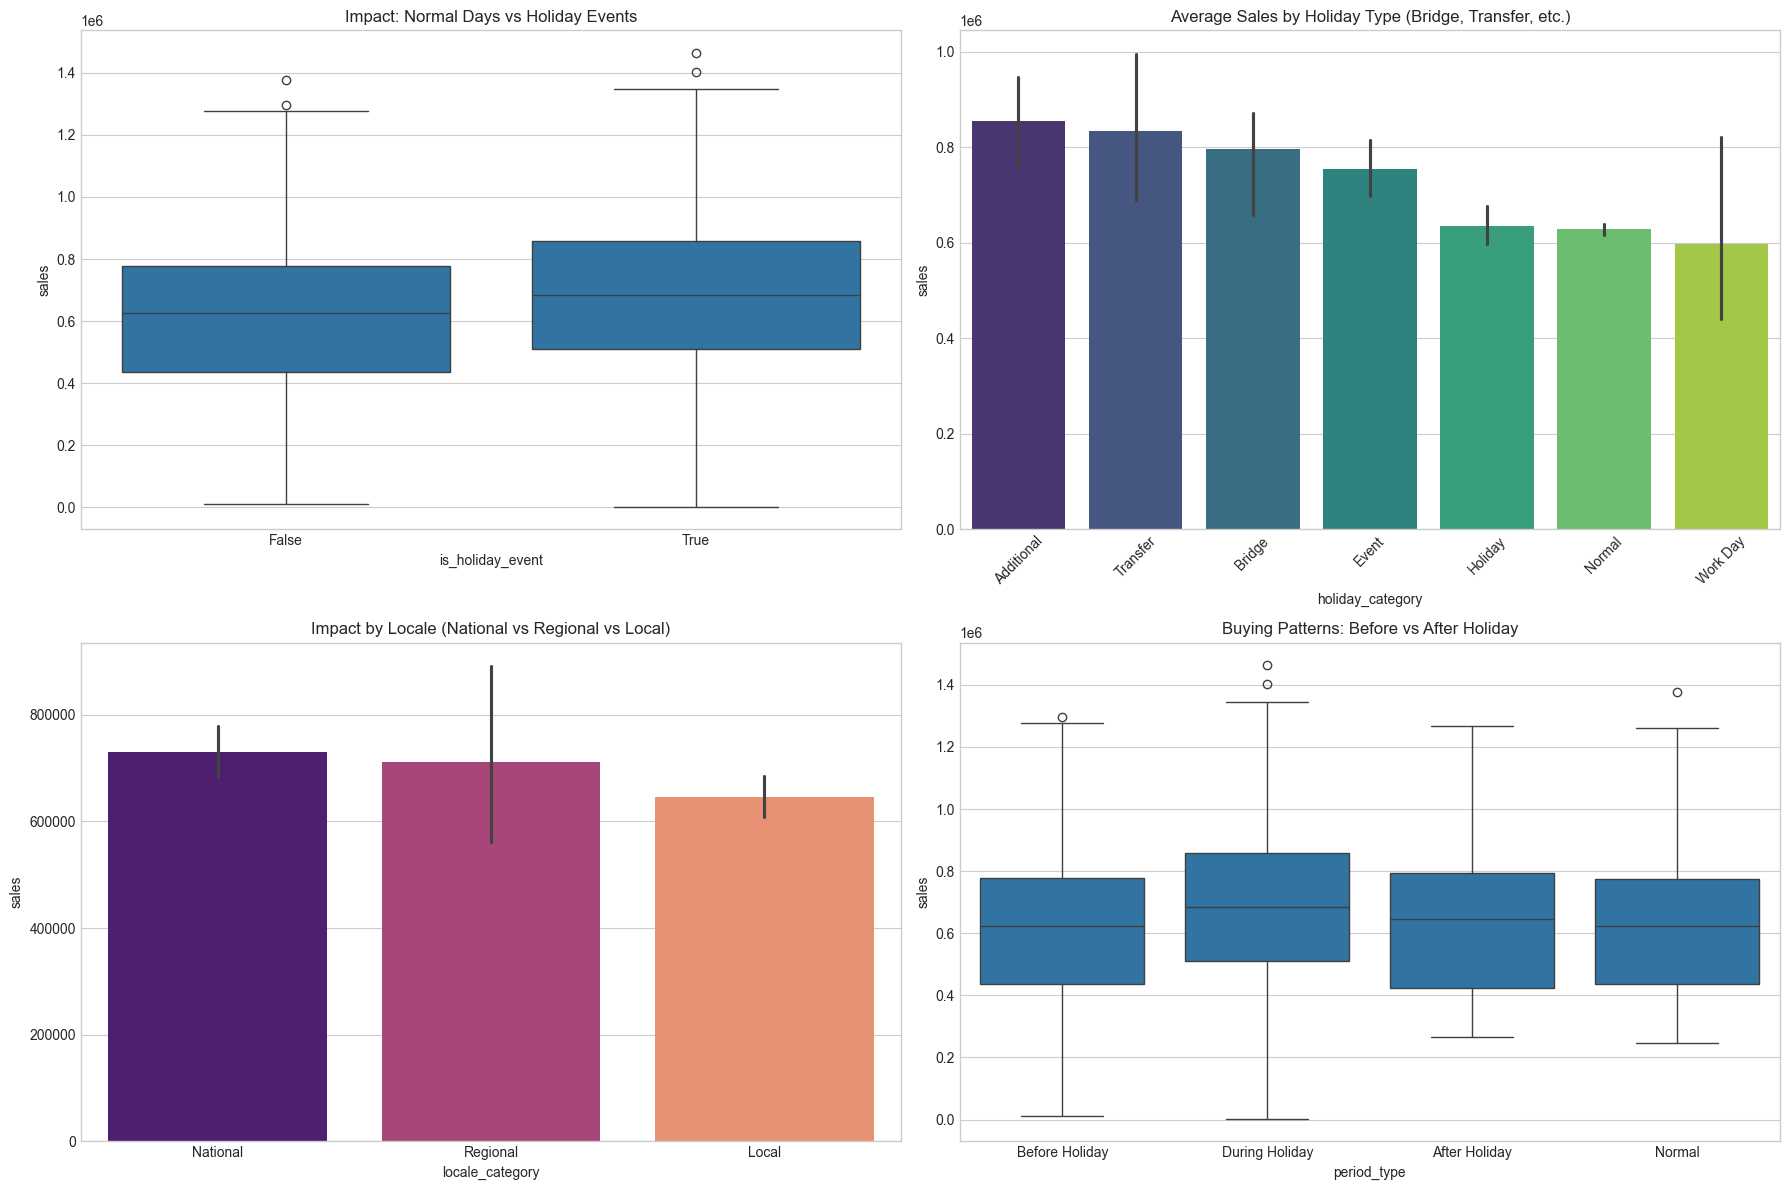

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# A. Boxplot Normal vs Holiday (General)
sns.boxplot(data=df, x='is_holiday_event', y='sales', ax=axes[0, 0])
axes[0, 0].set_title("Impact: Normal Days vs Holiday Events")

# B. Bar Chart: Holiday Types (Bridge vs Transfer vs Holiday)
# Trả lời: Bridge days có special không? Transferred có khác Original không?
type_order = df.groupby('holiday_category')['sales'].mean().sort_values(ascending=False).index
sns.barplot(data=df, x='holiday_category', y='sales', order=type_order, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title("Average Sales by Holiday Type (Bridge, Transfer, etc.)")
axes[0, 1].tick_params(axis='x', rotation=45)

# C. Bar Chart: Locale Impact (National vs Local)
# Trả lời: Local vs National impact khác nhau thế nào?
locale_order = df[df['locale_category']!='None'].groupby('locale_category')['sales'].mean().sort_values(ascending=False).index
sns.barplot(data=df[df['locale_category']!='None'], x='locale_category', y='sales', order=locale_order, ax=axes[1, 0], palette='magma')
axes[1, 0].set_title("Impact by Locale (National vs Regional vs Local)")

# D. Sales Pattern: Before/During/After
order_period = ['Before Holiday', 'During Holiday', 'After Holiday', 'Normal']
sns.boxplot(data=df, x='period_type', y='sales', order=order_period, ax=axes[1, 1])
axes[1, 1].set_title("Buying Patterns: Before vs After Holiday")

plt.tight_layout()
plt.show()

3.3 CALENDAR HEATMAP

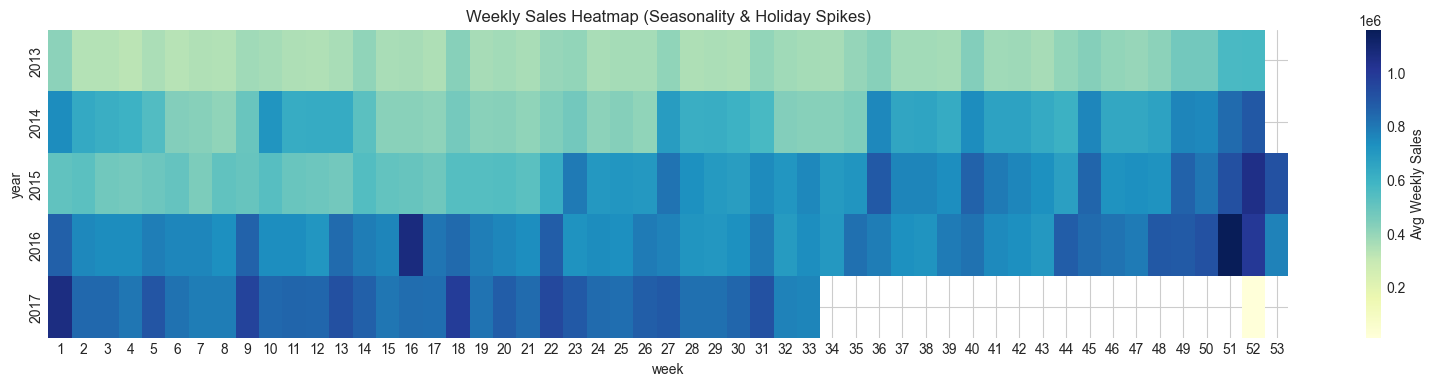

In [8]:
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
df['day_of_week'] = df['date'].dt.dayofweek

# Vì vẽ lịch 4 năm khá lớn, ta vẽ heatmap dạng Grid
pivot_sales = df.pivot_table(index='year', columns='week', values='sales', aggfunc='mean')
plt.figure(figsize=(20, 4))
sns.heatmap(pivot_sales, cmap='YlGnBu', cbar_kws={'label': 'Avg Weekly Sales'})
plt.title("Weekly Sales Heatmap (Seasonality & Holiday Spikes)")
plt.show()

3.4 EVENT ANALYSIS: EARTHQUAKE & ANOMALIES

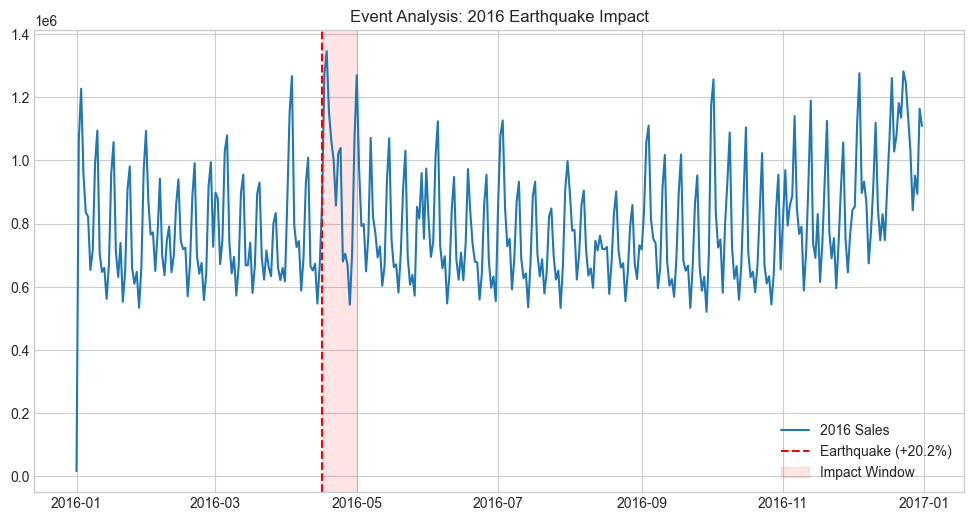

In [9]:
earthquake_date = pd.to_datetime("2016-04-16")
window = 15

# Tính toán impact
before = df[(df['date'] < earthquake_date) & (df['date'] >= earthquake_date - pd.Timedelta(days=window))]['sales'].mean()
after = df[(df['date'] > earthquake_date) & (df['date'] <= earthquake_date + pd.Timedelta(days=window))]['sales'].mean()
growth = (after - before) / before * 100

plt.figure(figsize=(12, 6))
# Zoom vào 2016
subset = df[(df['date'].dt.year == 2016)]
plt.plot(subset['date'], subset['sales'], label='2016 Sales')
plt.axvline(earthquake_date, color='red', linestyle='--', label=f'Earthquake (+{growth:.1f}%)')
# Highlight vùng bị ảnh hưởng
plt.axvspan(earthquake_date, earthquake_date + pd.Timedelta(days=window), color='red', alpha=0.1, label='Impact Window')
plt.title("Event Analysis: 2016 Earthquake Impact")
plt.legend()
plt.show()